In [1]:
%load_ext autoreload
%autoreload 2
%pip -q install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim

from agent import MyAgent
from models import DRQNetwork, MixingNetwork
from transferlearning import train

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cloned_policy_path = "./cloned_policy"
pretrained_mixer_path = "./pretrained_mixer"

cloned_policy_net = DRQNetwork.load(cloned_policy_path).to(device)
cloned_policy_net.gru.flatten_parameters()

num_agents = 4
central_state_size = 12 * num_agents + 901
mixer = MixingNetwork(
    num_agents=4,
    central_state_size=central_state_size,
    embedding_size=512,
    hypernet_size=512,
).to(device)

In [23]:
my_agent = MyAgent(
    num_agents=4,
    device=device,
    policy_net=cloned_policy_net,
    mixing_net=mixer,
    buffer_size=2000,
    batch_sequence_length=20,
    batch_size=64,
    lr=1e-4,
    gamma=0.99,
    epsilon=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.9995,
    target_update_freq=1,
    tau=1e-3,
    gradient_clipping_value=10,
)

# Freeze the policy
for p in my_agent.policy_net.parameters():
    p.requires_grad = False

my_agent.optimizer = optim.AdamW(my_agent.mixer.parameters(), lr=my_agent.lr)

trained_agent, all_rewards, all_losses = train(my_agent, num_episodes=100)

Using QMIX agent with mixer network
DRQNetwork(
  (feature_layer): Sequential(
    (0): Linear(in_features=42, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (gru): GRU(512, 512, num_layers=2, batch_first=True)
  (output_layer): Linear(in_features=512, out_features=7, bias=True)
)
MixingNetwork(
  (hyper_w1): Sequential(
    (0): Linear(in_features=949, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=512, out_features=2048, bias=True)
  )
  (hyper_w2): Sequential(
    (0): Linear(in_features=949, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (hyper_b1): Linear(in_features=949, out_features=512, bias=True)
  (hyper_b2): Sequential(
    (0): Linear(in_features=949, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)
Episode 1, Step 29, Reward: -60001.

Text(0, 0.5, 'TD-Loss')

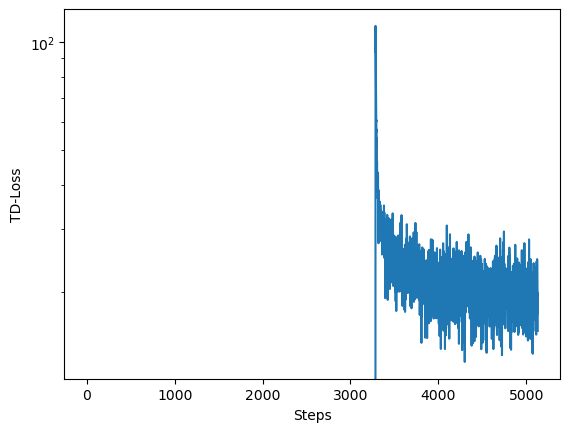

In [26]:
fig, ax = plt.subplots()
ax.semilogy(all_losses)
ax.set_xlabel("Steps")
ax.set_ylabel("TD-Loss")

In [28]:
trained_agent.mixer.save(pretrained_mixer_path)

Model saved to ./pretrained_mixer
